In [1]:
% matplotlib inline

import numpy as np
import pandas as pd
from cellfate import model, io, celldensity
import emcee
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as op

## The Data

This package accepts data in the form of csv files outputed by the CellProfiler Software available from MIT's Broad Institute (cellprofiler.org). 

The example data used here is processed time-lapse images of differentiating stem cells with tagged transcription factors.

<img src="cellfate/tutorial/t1.png" width="300" height="300">

The example cells are embryonic stem cells modified using CRISPR so as to create two tagged transcription factors: Oct4-mCherry and Sox2-GFP. These show up respectively in the red and green channels of our time lapse image set. Above is a composite image of the starting time point. Green cells become neurectoderm (Sox2 only), and red cells become mesendoderm (Oct4 only). 

CellProfiler can then be used to segment images and classify cells by relative color. A segmented version of the above image is shown below.

<img src="cellfate/tutorial/t1-segmented.png" width="300" height="300">

In this sample, cells were classified using the upper quartile intensity of each identified nuclei. The yellow color indicated red-dominated cells, the aqua indicates green-dominated, and navy and burgandy indicate the undifferentiated "both" cell state. 

<img src="cellfate/tutorial/t1-classified.png" width="300" height="300">

CellProfiler was then used to export the nuclear locations and classifications to a csv file. Our package is configured to read these default-configured CellProfiler output CSV files (created using the ExportToSpreadsheet analysis module).

The images shown above are for the first of 175 time steps in our sample data set. 

## I. Data Import

### (A) Import the CSV file
Data for the location of different cell types is imported from CSV files, which have to be put in a directory in the cellfate package. The default directory is 'test'. The CSV file should contain the following column headers:<br/>
- ##### For identitying labeling <br/>
  * Column 0:'ImageNumber': denoting the time step image
  * Column 1: 'ObjectNumber': denoting the arbitrary identity of the cell
- ##### For intensity classifications <br/>
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_high_Intensity_UpperQuartileIntensity_CellB_high'
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_high_Intensity_UpperQuartileIntensity_CellB_low'
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_low_Intensity_UpperQuartileIntensity_CellB_high'
  * 'Classify_Intensity_UpperQuartileIntensity_CellA_low_Intensity_UpperQuartileIntensity_CellB_low'<br/>
  (where 'CellA' and 'CellB' are the name of the two cell types)
- ##### For cell locations: <br/>
  * 'Location_Center_X': denoting the x coordinate of the cell location.
  * 'Location_Center_Y': denoting the y coordinate of the cell location.

The classification was done using the upper quartile intensity of each segmented cell. This is accessed in the function cell_density in the module celldensity.py. This function is capable of dividing the original image into a number of bins and counting the cell density in each bin.  

We can read in data directly using io.read, which would return an object with information of the measurement like the total duration, names of the cells, total number of bins and most importantly, a dataframe containing the calculated the cell density in every bin at different time.

In [2]:
# This is an example of reading the CSV using io.read.
# The image is divided into 2x2 bins in this example.

# Cautions:
# 1) the order of cell names has to follow that of CellA and CellB in the headers.
# 2) The original image is assumed to be a square image.
# 3) Since the default value of image size is 1024x1024, if your image is of different size,
#    you may have to add another parameter ImgWidth. 
# 4) The default linear length scale is 1.33 mm. You may change it by including the 
#    parameter length_scale (in mm)
# 5) The default time scale is 0.25 hours per time step. You may change it by including the 
#    parameter time_scale (in hours).

our_data=io.read('small_data_for_tutorial.csv', 'Sox2', 'Oct4', 2)

# To take a look at the cell density in different bin,
# we could just retrieve the attribute 'data'
# (The unit of the cell density is (/mm^2))
our_data.data

Sox2                       Oct4                        Both                \
      0     1      2      3      0      1      2      3      0      1      2   
0  11.0  32.0  116.0  568.0  122.0  268.0  294.0  117.0  204.0  758.0  719.0   
1  10.0  38.0  115.0  576.0  126.0  280.0  269.0  118.0  219.0  763.0  779.0   
2  11.0  28.0  110.0  575.0  128.0  310.0  270.0  119.0  215.0  786.0  799.0   

           
        3  
0  1076.0  
1  1121.0  
2  1107.0

In the above dataframe, the main columns are different cell types. The sub-columns are the index of the bin, which is in the same order as the usual way of labelling matrix element in python. The rows are different time points.

In [3]:
# Other attribute of the object output from io.read includes:

# 1) The names of the cell
cellnameA,cellnameB = our_data.cellname
print('The cells involved are',cellnameA,'and',cellnameB)

# 2) How many number of bin is divided into in one direction
print('The image is divided into',our_data.bin_num,'x',our_data.bin_num,'bins.')

# 3) How many time steps are in the measurement
print('The measurement includes',our_data.tot_time,'images.')

# 4) What is the scale of each time steps (in hours)
print('The time scale of each time step is',our_data.time_scale,'hours.')

# 5) What the linear length scale of the image (in mm)
print('The legnth size the image is',our_data.length_scale,'mm.')

The cells involved are Sox2 and Oct4
The image is divided into 2 x 2 bins.
The measurement includes 3 images.
The time scale of each time step is 0.25 hours.
The legnth size the image is 1.33 mm.


### (B) Take a look at the cell distribution

Very often, although it is not necessary, it is useful to get an idea of how the cell distribution in the data would look like so that we can do the analysis with more intuition.<br/>

This can be done by the function draw_cell_loc in the celldensity module. You could just choose what time of cell distribution you want to look at.

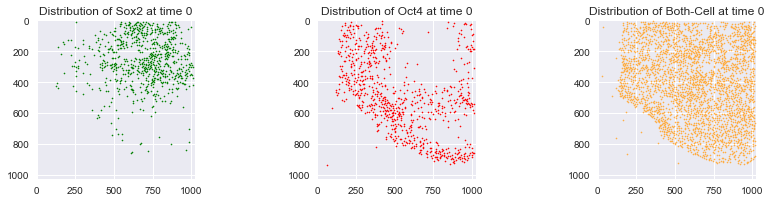

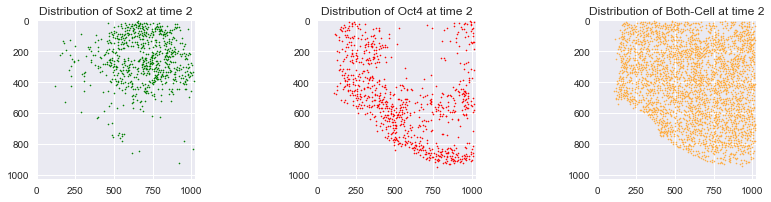

In [4]:
# Take a look at the cell distribution at time step 0
celldensity.draw_cell_loc('small_data_for_tutorial.csv', 'Sox2', 'Oct4', 0)

# Take a look at the cell distribution at time step 2
celldensity.draw_cell_loc('small_data_for_tutorial.csv', 'Sox2', 'Oct4', 2)

Since we are going to divide the image into bins and count the cell density in each of them, we could also use the draw_cell_loc function to look at the cell distribution a specfied bin. <br/>

(Note that every index, including time index, bin coordinates and bin index start from 0, as the python convention)

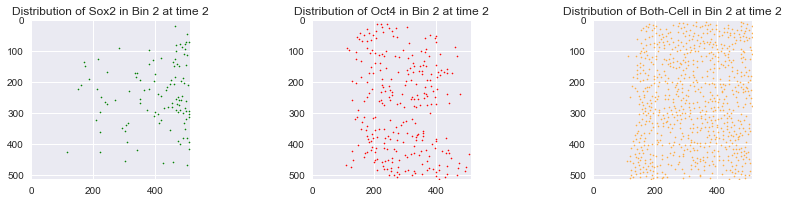

In [5]:
# If we divide the image into 2x2 bins (=> BinDiv =2)
# and we want to take a look at the cell distribution at time step 2 
# in bin (1,0) (=> bin_i=1, bin_j=0) so that whose bin index would be 1*BinDiv+0=2.
celldensity.draw_cell_loc('small_data_for_tutorial.csv', 'Sox2', 'Oct4', 2, BinDiv=2, bin_i=1, bin_j=0)

## II. Inference

## Model

This package includes two models: 1) the model without diffusion, and 2) the model accounting for the diffusion.

### 1) Model without diffusion

The model without diffusion is specified in the function "model_uncoupled" of model.py. The function is defined inside the function "solver_uncoupled". The detailed explanation on the model could be found in model.ipynb. The model is generated with the following system of differential equations:

$$ \frac{d n_b (t,x,y)}{dt}  = k_{division} n_b(t,x,y) - (k_{b\rightarrow g } + k_{b \rightarrow r})n_{b}(t,x,y) $$
$$ \frac{d n_g (t,x,y)}{dt} = k_{division}n_g(t,x,y) + k_{b\rightarrow g } n_{g}(t,x,y) $$
$$ \frac{d n_r (t,x,y)}{dt} = k_{division}n_r(t,x,y) + k_{b\rightarrow r } n_{r}(t,x,y) $$

#### MCMC Run

With the created celldensity object, we can run MCMC by using the model module. Before the actual MCMC run, I'd like to define a few helper functions which will help our analysis.

In [17]:
def plot_chain(sampler, coupled, nwalkers=10):
    '''
    Plots the traces of walkers from MCMC run.
    
    Arguments:
        sampler: Ensemble sampler from emcee package which underwent MCMC run
        coupled: True if we use model with diffusion. False if we use model without diffusion.
        nwalkers: number of walkers to plot
    '''
    if coupled:
        fig, (ax_k_div, ax_k_bg, ax_k_br, ax_k_mov) = plt.subplots(4)
        ax_k_div.set(ylabel='k_div')
        ax_k_bg.set(ylabel='k_bg')
        ax_k_br.set(ylabel='k_br')
        ax_k_mov.set(ylabel='k_mov')
        for i in range(nwalkers):
            sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
            sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
            sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)
            sns.tsplot(sampler.chain[i,:,3], ax=ax_k_mov)
    else:
        fig, (ax_k_div, ax_k_bg, ax_k_br) = plt.subplots(3)
        ax_k_div.set(ylabel='k_div')
        ax_k_bg.set(ylabel='k_bg')
        ax_k_br.set(ylabel='k_br')
        for i in range(nwalkers):
            sns.tsplot(sampler.chain[i,:,0], ax=ax_k_div)
            sns.tsplot(sampler.chain[i,:,1], ax=ax_k_bg)
            sns.tsplot(sampler.chain[i,:,2], ax=ax_k_br)
            
def plot_kdes(sampler, coupled, burntime=300):
    '''
    Plots joint kde plots of parameters estimated from the MCMC run.
    Returns the list of median values of estimated parameters from their respective distributions.
    
    Arguments:
        sampler: Ensemble sampler from emcee package which underwent MCMC run
        coupled: True if we use model with diffusion. False if we use model without diffusion.
        burntime: Burn-in time of MCMC run
    '''
    samples = sampler.chain[:,burntime:,:]
    
    if coupled:
        ndim = 4
        # reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
        traces = samples.reshape(-1, ndim).T

        # Create a pandas DataFrame with labels.
        parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 
                                          'k_br': traces[2], 'k_mov': traces[3]})

        # Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
        g = sns.PairGrid(parameter_samples)
        g.map_diag(sns.kdeplot)
        g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);        

        k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), \
             parameter_samples['k_br'].median(), parameter_samples['k_mov'].median()]
        print('k_div = %.5f' % (parameter_samples['k_div'].median()))
        print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
        print('k_br = %.5f' % (parameter_samples['k_br'].median()))        
        print('k_mov = %.5f' % (parameter_samples['k_mov'].median()))     
        
        return k
        
    else:
        ndim = 3
        # reshape the samples into an array with dimension (ndim) x (# of data) 1D array 
        traces = samples.reshape(-1, ndim).T

        # Create a pandas DataFrame with labels.
        parameter_samples = pd.DataFrame({'k_div': traces[0], 'k_bg': traces[1], 'k_br': traces[2]})

        # Draw joint_kde plot (Referred to: http://seaborn.pydata.org/tutorial/distributions.html)
        g = sns.PairGrid(parameter_samples)
        g.map_diag(sns.kdeplot)
        g.map_offdiag(sns.kdeplot, cmap="Blues_d", n_levels=6);

        k = [parameter_samples['k_div'].median(), parameter_samples['k_bg'].median(), parameter_samples['k_br'].median()]
        print('k_div = %.5f' % (parameter_samples['k_div'].median()))
        print('k_bg = %.5f' % (parameter_samples['k_bg'].median()))
        print('k_br = %.5f' % (parameter_samples['k_br'].median()))        
        
        return k

def plot_heatmap(theta, data, coupled, plotNum=4):
    '''
    Plot the heatmap of each type of cell over time.
    
    Arguments:
        theta: a list of parameters for generative model
        data: Celldensity object containing experimental data
        coupled: True if we use model with diffusion. False if we use model without diffusion.
        plotNum : number of snapshots (plots). 
                  The time difference between each snapshot is even.    
    '''

    dt = data.time_scale
    # Heatmap for the actual data
    grid = data.pd2np()
    time_step = int(data.tot_time/plotNum)
    grn = grid[0,:,:,:] 
    red = grid[1,:,:,:]
    both = grid[2,:,:,:]

    plt.figure()
    plt.suptitle('Data')
    # Plot heatmap for each time i*time_step
    for i in range(plotNum):
        plt.subplot(plotNum,3,1+i*3)
        ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=150,
                    cmap="Greens", xticklabels=False, yticklabels=False)
        ax_g.invert_yaxis()

        plt.subplot(plotNum,3,2+i*3)
        ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=150,
                    cmap="Reds", xticklabels=False, yticklabels=False)
        ax_r.invert_yaxis()

        plt.subplot(plotNum,3,3+i*3)
        ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=150, 
                    cmap="Oranges", xticklabels=False, yticklabels=False)
        ax_b.invert_yaxis()

        ax_g.set_title('Sox2 at t=%.1f' % (i*time_step*dt))
        ax_r.set_title('Oct4 at t=%.1f' % (i*time_step*dt))
        ax_b.set_title('Both at t=%.1f' % (i*time_step*dt))


    # Heatmap for the model
    if coupled: 
        grid = model.solver_coupled(theta, data)
    else: 
        grid = model.solver_uncoupled(theta, data)

    time_step = int(data.tot_time/plotNum)
    grn = grid[0,:,:,:] 
    red = grid[1,:,:,:]
    both = grid[2,:,:,:]

    plt.figure()
    plt.suptitle('Model')
    # Plot heatmap for each time i*time_step
    for i in range(plotNum):
        plt.subplot(plotNum,3,1+i*3)
        ax_g = sns.heatmap(grn[1:-1,1:-1,i*time_step], vmin=0, vmax=150,
                    cmap="Greens", xticklabels=False, yticklabels=False)
        ax_g.invert_yaxis()

        plt.subplot(plotNum,3,2+i*3)
        ax_r = sns.heatmap(red[1:-1,1:-1,i*time_step], vmin=0, vmax=150,
                    cmap="Reds", xticklabels=False, yticklabels=False)
        ax_r.invert_yaxis()

        plt.subplot(plotNum,3,3+i*3)
        ax_b = sns.heatmap(both[1:-1,1:-1,i*time_step], vmin=0, vmax=150,
                    cmap="Oranges", xticklabels=False, yticklabels=False)
        ax_b.invert_yaxis()

        ax_g.set_title('Sox2 at t=%.1f' % (i*time_step*dt))
        ax_r.set_title('Oct4 at t=%.1f' % (i*time_step*dt))
        ax_b.set_title('Both at t=%.1f' % (i*time_step*dt))


Firstly, we want to set our starting position for parameter $\vec{k}$ estimation. We use either leastsq or least_squares functions from scipy.optimize package to find a position which maximizes the likelihood function. These functions require residual as their input, and model module provides the residual by "residual" function which is supposed to be minimized using these functions. While leastsq function would be most efficient choice as it uses Levenberg-Marquardt algorithm, the algorithm is designed to explore the unbounded parameter space. Unfortunately, in some cases, it reults in negative values of some components in $\vec{k}$. In this case, one may use 'trf' method provided by least_squares function, which accepts the bounds on the optimization process.

Please note that following demonstration will be done with the full dataset which is not stored in the github. You can import of your data after storing it in the test folder and follow the exactly same procedure.

$\textbf{One important instruction}$: the code is designed so that for the inference on nxn bins, we use (n+2)x(n+2) grid and ignore bins on the four edges. The reason will be clear if you read the explanation on the next model. Briefly speaking, the model with diffusion uses finite difference method, which excludes bins on the edges. Thus, for the valid comparison, we also exclude boundary bins in the model without diffusion.

In [7]:
# Import data
# We will simulate for 4x4 bin, which means we need 6x6 grid.
bin_6x6 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 6)

In [8]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.5, 0.5])
res = op.leastsq(model.residual, x0, args=(bin_6x6, -0.15, 0.1, False)) # We use false to indicate that our model is uncoupled

print(res[0])

[ 0.02343513  0.00377315  0.00873949]


Now, we use "run_mcmc" function from the model module.

In [9]:
help(model.run_mcmc)

Help on function run_mcmc in module cellfate.model:

run_mcmc(data, init_params, coupled, nwalkers=20, nsteps=500, spread=None, mu_n=-0.15, sigma_n=0.1, threadsNum=4)
    Runs MCMC using  Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble 
    sampler from emcee package.
    Returns the sampler object after MCMC run.
    
    Arguments:
        data: CellDen class object
        init_params: Initial position to start MCMC
        coupled: True if one uses model with diffusion &
                Fals if one uses model without diffusion
        nwalkers: number of walkers for MCMC (optional)
        nsteps: number of steps for MCMC (optional)
        spread: parameter that spreads the starting position for MCMC (optional)
                It will be multiplied to the n-dimensional Gausssian ball to
                vary the starting position for each walker
        mu_n: mean of the log distribution of counting error (optional)
        sigma_n: standard deviation of the log distribut

In [10]:
# Run the sampler.
%time sampler=model.run_mcmc(bin_6x6, res[0], False)
print('Done')

CPU times: user 7.15 s, sys: 573 ms, total: 7.72 s
Wall time: 1min 4s
Done


#### Visualizing MCMC run

Here, our pre-defined helper functions will come handy.

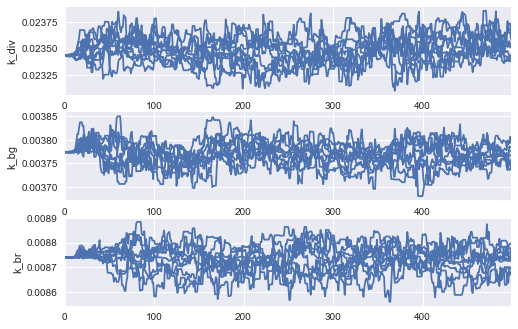

In [11]:
# Plot a few traces of MCMC run
plot_chain(sampler, False)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02348
k_bg = 0.00377
k_br = 0.00873


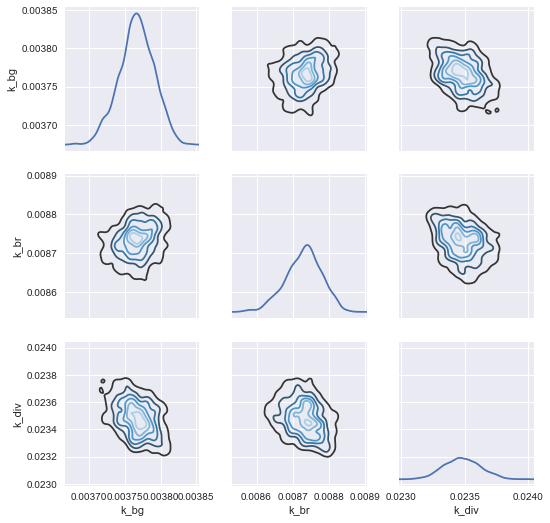

In [12]:
# Draw joint_kde plot
# Note that MCMC run converged pretty quickly so that preset burnin time of 300 steps is acceptable in this case

k_4x4_uncoupled = plot_kdes(sampler, False)

The value of each component of $\vec{k}$ presented above is median from each distribution. We can draw heatmaps to compare actual data and the model generated by the estimated parameters.

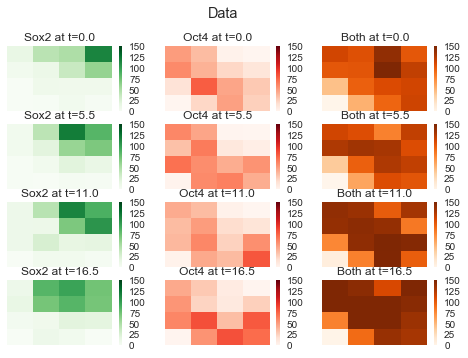

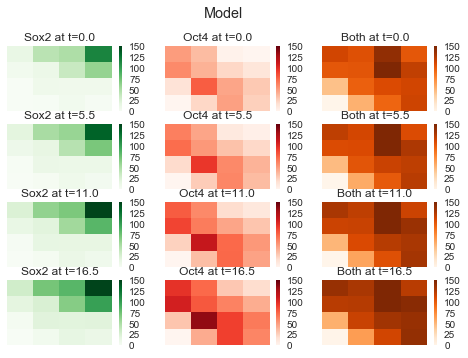

In [18]:
plot_heatmap(k_4x4_uncoupled, bin_6x6, False)

### 2) Model with diffusion

The model with diffusion is specified in the function "solver_coupled" of model.py. The detailed explanation on the model could be found in model.ipynb. The model uses following system of PDEs:

\begin{align*}
\frac{\partial n_b}{\partial t}&=k_{move}\nabla^2 n_b+k_{division}n_b-(k_{b\rightarrow g}+k_{b\rightarrow r})n_b \\
\frac{\partial n_g}{\partial t}&=k_{move}\nabla^2 n_g+k_{division}n_g+k_{b\rightarrow g}n_b\\
\frac{\partial n_r}{\partial t}&=k_{move}\nabla^2 n_r+k_{division}n_r+k_{b\rightarrow r}n_b
\end{align*}

The PDE is approximated by finite difference method (Reference: http://ipython-books.github.io/featured-05/). Then the laplacian and time derivative will be approximated as

\begin{align*}
\nabla^2 n(t,x,y) &\simeq \frac{n(t,x+1,y)+n(t,x-1,y)+n(t,x,y+1)+n(t,x,y-1) - 4n(t,x,y)}{dx^2} \\
\frac{\partial n(t,x,y)}{\partial t} &\simeq \frac{n(t+dt,x,y)-n(t,x,y)}{dt}
\end{align*}

We apply Neumann boundary condition which requires the spatial derivatives are zero on the boundaries of our area of interest. The boundary condition is applied by setting the values at the edge bins same as the values at the bins right before the edge. With the condition, to ensure numerical convergence, we also apply Neumann stability condition:
$$dt \leq \frac{dx^2}{2}$$

The above conditions are all incorporated in the "solver_coupled" function. Note that in this scheme, we exclude boundary of the grid. Thus, to simulate nxn grid, we need (n+2)x(n+2) grid.

Given the above discussion, we simply repeat the procedure delineated for the other model.

#### MCMC run

In [19]:
# Import data
# We will simulate for 4x4 bin, which means we need 6x6 grid.
bin_6x6 = io.read('expt128_1-88SoxNuclei.csv', 'Sox2', 'Oct4', 6)

In [20]:
# Find MAP values
# Initial guess
x0 = np.array([0.1, 0.1, 0.1, 0.1])
res = op.leastsq(model.residual, x0, args=(bin_6x6, -0.15, 0.1, True)) # We use True to indicate that our model is coupled

print(res[0])

[ 0.02219682  0.00257173  0.00016294  0.00021555]


In [21]:
# Run the sampler.
%time sampler=model.run_mcmc(bin_6x6, res[0], True)
print('Done')

CPU times: user 7.8 s, sys: 676 ms, total: 8.48 s
Wall time: 9min 20s
Done


#### Visualizing MCMC run

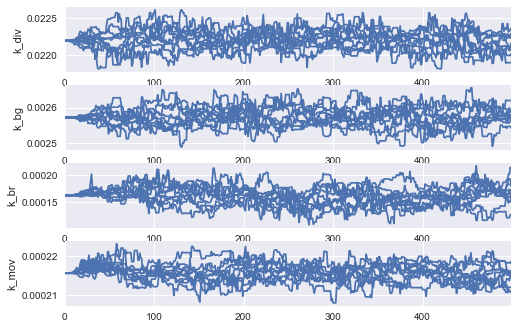

In [22]:
# Plot a few traces of MCMC run
plot_chain(sampler, True)

/Users/lsh/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/Users/lsh/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


k_div = 0.02220
k_bg = 0.00257
k_br = 0.00016
k_mov = 0.00022


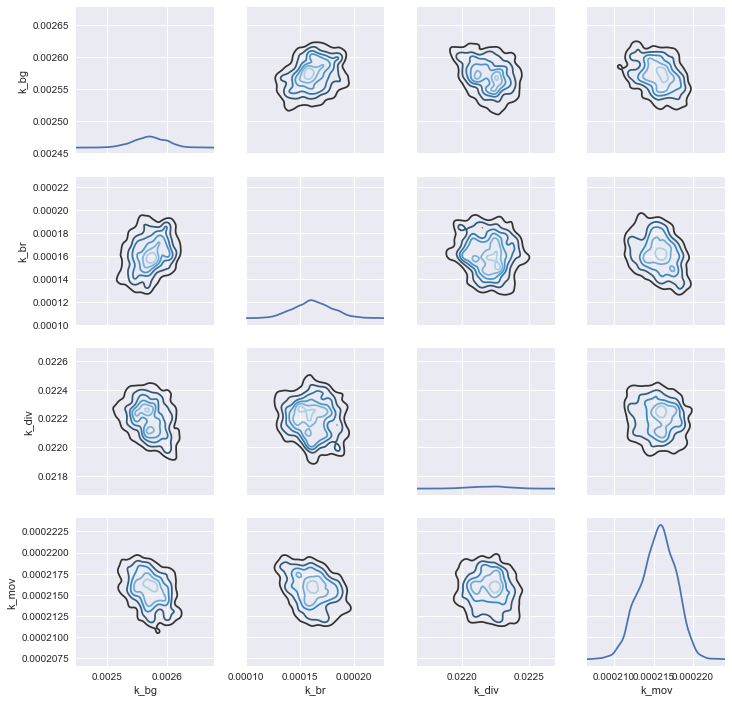

In [23]:
# Draw joint_kde plot
# Note that MCMC run converged pretty quickly so that preset burnin time of 300 steps is acceptable in this case
k_4x4_coupled = plot_kdes(sampler, True)

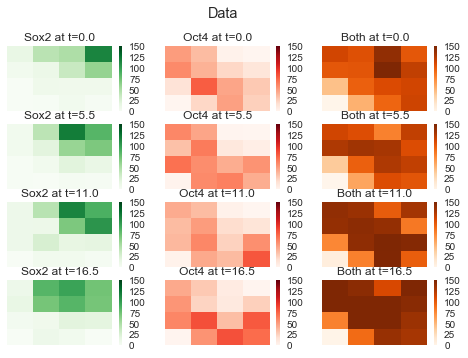

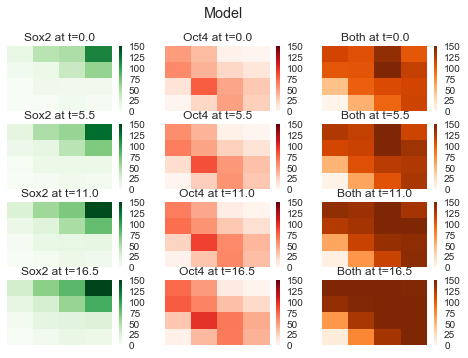

In [24]:
plot_heatmap(k_4x4_coupled, bin_6x6, True)

Due to the excessive size, supplementary materials for the final paper are separately provided in the Inference.ipynb.